In [1]:
start_simulation = '2017-10-01' #YYYY-MM-DD
end_simulation = '2021-12-31' #YYYY-MM-DD
portfolios = [
    {
        'portfolio_name' : 'BTC <-> ETH dummy 10/5',
        'buy_decision_model' : 'dummy',
        'price_decision_model' : 'dummy_10_5',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 10000, # purely for lambda memory considerations
        'starting_funds' : 1,    
    },
    
    {
        'portfolio_name' : 'ETH <-> BTC dummy 10/5',
        'buy_decision_model' : 'dummy',
        'price_decision_model' : 'dummy_10_5',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000, # purely for lambda memory considerations
        'starting_funds' : 1,    
    },
]

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re

# models
import buy_decision
import price_decision

In [3]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [4]:
import datetime
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # validate model names too!
    # TODO: validate model names

In [5]:
def get_pair_data(base_coin, other_coin):
    sql = f"""
    select
        p.*,
        (p.coin2 = '{base_coin}') as reverse
    from pairs p
    where
        (p.coin1 = '{base_coin}' and p.coin2 = '{other_coin}')
            or
        (p.coin2 = '{base_coin}' and p.coin1 = '{other_coin}')
    """
    df = pd.read_sql_query(sql, conn)
    if len(df) == 0:
        return None
    else:
        return df.iloc[0]

In [6]:
def get_batch_data(pair_id, start_time, end_time, batch_size, reverse):
    # TODO: this needs to be expanded to include engineered features
    sql = f"""
    select * from candlestick_15m cm 
    where
        cm.pair_id = {pair_id}
        and cm.close_time notnull
        and cm.open_time between '{start_time}' and '{end_time}'
    order by cm.open_time limit {batch_size}
    """
    df = pd.read_sql_query(sql, conn)

    if reverse:
        # maybe a better way to specify the columns?
        df[['open', 'high', 'low', 'close']] = 1/df[['open', 'high', 'low', 'close']]
    return df

In [7]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    buy_decision_model = portfolio['buy_decision_model']
    price_decision_model = portfolio['price_decision_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    starting_funds = portfolio['starting_funds']
    
    pair_data = get_pair_data(starting_coin, pair_coin)

    buy_model = buy_decision.__dict__[buy_decision_model]
    price_model = price_decision.__dict__[price_decision_model]
    buy_columns = buy_model.columns()
    price_columns = price_model.columns()
    stop_loss_trigger = None
    target_trigger = None

    current_time = start_time
    all_output = []

    while True:
        # this batch data should also include feature engineering
        batch_data = get_batch_data(pair_data['id'], current_time, end_time, max_batch_size, pair_data['reverse'])

        if len(batch_data) == 0:
            break

        batch_buy_decision = buy_decision.__dict__[buy_decision_model].make_decision(batch_data[buy_columns].values)
        batch_price_decision = price_decision.__dict__[price_decision_model].stop_loss_target_range(batch_data[price_columns].values)
        output = batch_data[['open_time','open', 'high', 'low', 'close']].copy()
        output['buy_decision'] = batch_buy_decision
        output[['target_price', 'stop-loss_price']] = batch_price_decision

        all_output.append(output)
        current_time = batch_data['close_time'].max()

    results = pd.concat(all_output).set_index('open_time')

    results[['fund1','fund2','action']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    for x,r in results.iterrows():
        if cur_funds[0] > 0:
            if r['buy_decision'] == True:
                cur_funds[1] = (cur_funds[0] * r['close'])
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                stop_loss_trigger = r['stop-loss_price']
                target_trigger = r['target_price']
                results.loc[x,'action'] = 'buy'

        else:
            if r['high'] <= target_trigger:
                cur_funds[0] = (cur_funds[1] / target_trigger)
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'sell target'
            elif r['low'] >= stop_loss_trigger:
                cur_funds[0] = (cur_funds[1] / stop_loss_trigger)
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'sell stop-loss'
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['action'] = results['action'].fillna('none')
    return portfolio_name, results

In [8]:
simulation_results = {}

for p in portfolios:
    print(f"Simulating \"{p['portfolio_name']}\"")
    name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res

Simulating "BTC <-> ETH dummy 10/5"
Simulating "ETH <-> BTC dummy 10/5"


In [9]:
for k,v in simulation_results.items():
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['action']!='none'])
    display(v['action'].value_counts())

BTC <-> ETH dummy 10/5
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,buy_decision,target_price,stop-loss_price,fund1,fund2,action,total_value
open_time,,,,,,,,,,,
2017-10-01 03:30:00,14.308813,14.305538,14.423770,14.383108,True,12.877932,15.024253,0.000000,14.383108,buy,1.000000
2017-10-02 19:15:00,14.956178,14.837896,15.037594,14.930944,False,13.460561,15.703987,0.957326,0.000000,sell stop-loss,0.957326
2017-10-03 00:45:00,14.617960,14.617960,14.788087,14.733182,True,13.156164,15.348858,0.000000,14.104458,buy,0.957326
2017-10-09 04:00:00,15.256461,15.210282,15.384615,15.299644,False,13.730815,16.019284,0.918926,0.000000,sell stop-loss,0.918926
2017-10-09 14:30:00,15.226494,15.214448,15.468861,15.464555,True,13.703845,15.987819,0.000000,14.210776,buy,0.918926
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 00:15:00,17.380423,17.346956,17.511601,17.482517,True,15.642380,18.249444,0.000000,3.767436,buy,0.215497
2021-06-30 19:30:00,15.687997,15.556212,15.695877,15.566867,False,14.119197,16.472397,0.240848,0.000000,sell target,0.240848
2021-06-30 22:00:00,15.373026,15.365704,15.497629,15.467665,True,13.835724,16.141678,0.000000,3.725356,buy,0.240848


none              131295
buy                  399
sell stop-loss       308
sell target           90
Name: action, dtype: int64

ETH <-> BTC dummy 10/5
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,buy_decision,target_price,stop-loss_price,fund1,fund2,action,total_value
open_time,,,,,,,,,,,
2017-10-01 02:45:00,0.069305,0.069798,0.069200,0.069708,True,0.062375,0.072770,0.000000,0.069708,buy,1.000000
2017-10-09 18:00:00,0.062192,0.062192,0.061199,0.062033,False,0.055973,0.065302,1.117572,0.000000,sell target,1.117572
2017-10-09 19:45:00,0.059186,0.060469,0.058810,0.060278,True,0.053267,0.062145,0.000000,0.067365,buy,1.117572
2017-10-10 10:15:00,0.062174,0.062553,0.062174,0.062365,False,0.055957,0.065283,1.083992,0.000000,sell stop-loss,1.083992
2017-10-10 11:30:00,0.062060,0.062499,0.062007,0.062489,True,0.055854,0.065163,0.000000,0.067738,buy,1.083992
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-22 08:30:00,0.058906,0.059398,0.058727,0.059395,True,0.053015,0.061851,0.000000,0.335595,buy,5.650216
2021-06-30 17:30:00,0.062033,0.062222,0.061869,0.062048,False,0.055830,0.065135,5.425829,0.000000,sell stop-loss,5.425829
2021-06-30 18:30:00,0.062288,0.063193,0.062288,0.063176,True,0.056059,0.065402,0.000000,0.342782,buy,5.425829


none              131537
buy                  278
sell stop-loss       197
sell target           80
Name: action, dtype: int64

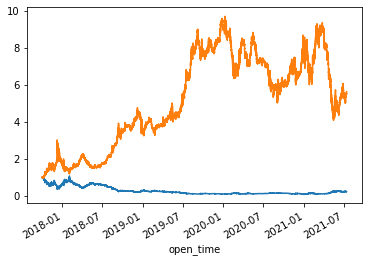

In [10]:
for k,v in simulation_results.items():
    v.total_value.plot()